# LSTM Model

In [2]:
# Let's start by reading the full dataset to identify top correlating features with the 'Winner' column.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt


In [3]:
# Load the dataset
file_path = '../StarCraft_Combined_Dataset.csv'
data = pd.read_csv(file_path)
# data.drop(columns=["Player1_Race","Player2_Race"],axis=1,inplace=True)
# label encode player races
label_encoder = LabelEncoder()
label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


# Drop columns with non-numeric data (except for 'Player1_Race' and 'Player2_Race', which we'll one-hot encode)
data_numeric = data.select_dtypes(include=[np.number])

# Calculate correlations with the 'Winner' column
correlations = data_numeric.corrwith(data_numeric['Winner']).sort_values(ascending=False)

# Select top 5 correlating features (excluding 'Winner' itself)
top_features = correlations.index[1:10]  # Excluding 'Winner' which is at the top

# Function to filter groups with at least 120 rows
def filter_groups(group):
    if len(group) >= 120:
        return group.iloc[:120]  # Return only the first 120 rows

# Group by 'replayID', apply the filter function
filtered_groups = data.groupby('ReplayID').apply(filter_groups).reset_index(drop=True)

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [4]:
# Add races back for one-hot encoding
features_to_use = list(top_features) + ["ReplayID"]
X = filtered_groups[features_to_use]
y = filtered_groups['Winner']

# Convert 1 to 0 and 2 to 1
y_encoded = y.apply(lambda x: 0 if x == 1 else 1)
y_encoded = y_encoded[X.index]

# Preprocess the dataset
numeric_features = top_features
# categorical_features = ['Player1_Race', 'Player2_Race']

# Assuming filtered_groups is your DataFrame from the previous step
unique_replay_ids = filtered_groups['ReplayID'].unique()

# Split the unique replay IDs into train and test sets
train_replay_ids, test_replay_ids = train_test_split(unique_replay_ids, test_size=0.2, random_state=42)

# Use the replay IDs to separate the original filtered_groups into train and test DataFrames
train_X_data = X[X['ReplayID'].isin(train_replay_ids)]
test_X_data = X[X['ReplayID'].isin(test_replay_ids)]
train_y_data = y_encoded[X['ReplayID'].isin(train_replay_ids)]
test_y_data = y_encoded[X['ReplayID'].isin(test_replay_ids)]

In [5]:
# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
        ]
)

In [22]:
# Build the LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(60,return_sequences=True,input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Final Preprocessing

# Preprocess the data
preprocessor.fit(filtered_groups)
X_train_processed = preprocessor.transform(train_X_data)
X_test_processed = preprocessor.transform(test_X_data)

# Reshape data for LSTM input
feature_columns = [col for col in train_X_data.columns if col not in ['ReplayID', 'Winner']]
X_train_reshaped = X_train_processed.reshape(-1, 120, len(feature_columns))
X_test_reshaped = X_test_processed.reshape(-1, 120, len(feature_columns))

# Create a mapping from ReplayID to label
replay_id_to_label_map = {replay_id: label for replay_id, label in zip(X['ReplayID'], y_encoded)}

# Now, extract the labels for the training and testing ReplayIDs in the correct order
train_y_data = np.array([replay_id_to_label_map[replay_id] for replay_id in train_replay_ids])
test_y_data = np.array([replay_id_to_label_map[replay_id] for replay_id in test_replay_ids])

In [23]:
# Build and train the model
model = build_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, train_y_data, epochs=100, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])


# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, test_y_data, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

Epoch 1/100
122/122 [==============================] - 6s 30ms/step - loss: 0.6735 - accuracy: 0.6071 - val_loss: 0.6874 - val_accuracy: 0.5806
Epoch 2/100
122/122 [==============================] - 3s 26ms/step - loss: 0.6680 - accuracy: 0.6178 - val_loss: 0.6949 - val_accuracy: 0.5806
Epoch 3/100
122/122 [==============================] - 3s 25ms/step - loss: 0.6621 - accuracy: 0.6240 - val_loss: 0.6834 - val_accuracy: 0.5945
Epoch 4/100
122/122 [==============================] - 3s 25ms/step - loss: 0.6618 - accuracy: 0.6224 - val_loss: 0.6800 - val_accuracy: 0.5991
Epoch 5/100
122/122 [==============================] - 3s 26ms/step - loss: 0.6577 - accuracy: 0.6219 - val_loss: 0.6978 - val_accuracy: 0.5899
Epoch 6/100
122/122 [==============================] - 3s 26ms/step - loss: 0.6584 - accuracy: 0.6189 - val_loss: 0.6882 - val_accuracy: 0.5760
Epoch 7/100
122/122 [==============================] - 3s 25ms/step - loss: 0.6585 - accuracy: 0.6347 - val_loss: 0.6905 - val_accuracy:

In [24]:
# Save LSTM Model

model.save("Combined_Replays_LSTM_Model.h5")

### Sequence Length Accuracy Comparison

c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 0.6957 - accuracy: 0.4990 - val_loss: 0.6964 - val_accuracy: 0.4714
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 0.6950 - accuracy: 0.5093 - val_loss: 0.6942 - val_accuracy: 0.4802
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6955 - accuracy: 0.4927 - val_loss: 0.6944 - val_accuracy: 0.4714
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6939 - accuracy: 0.5255 - val_loss: 0.6920 - val_accuracy: 0.5198
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.5132 - val_loss: 0.6956 - val_accuracy: 0.4714
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6941 - accuracy: 0.5108 - val_loss: 0.6939 - val_accuracy: 0.4714
Epoch 7/100
128/128 [==============================] - 1s 5ms/step - loss: 0.6947 - accuracy: 0.5142 - val_loss: 0.6914 - val_accuracy: 0.519

ValueError: x and y must have same first dimension, but have shapes (14,) and (11,)

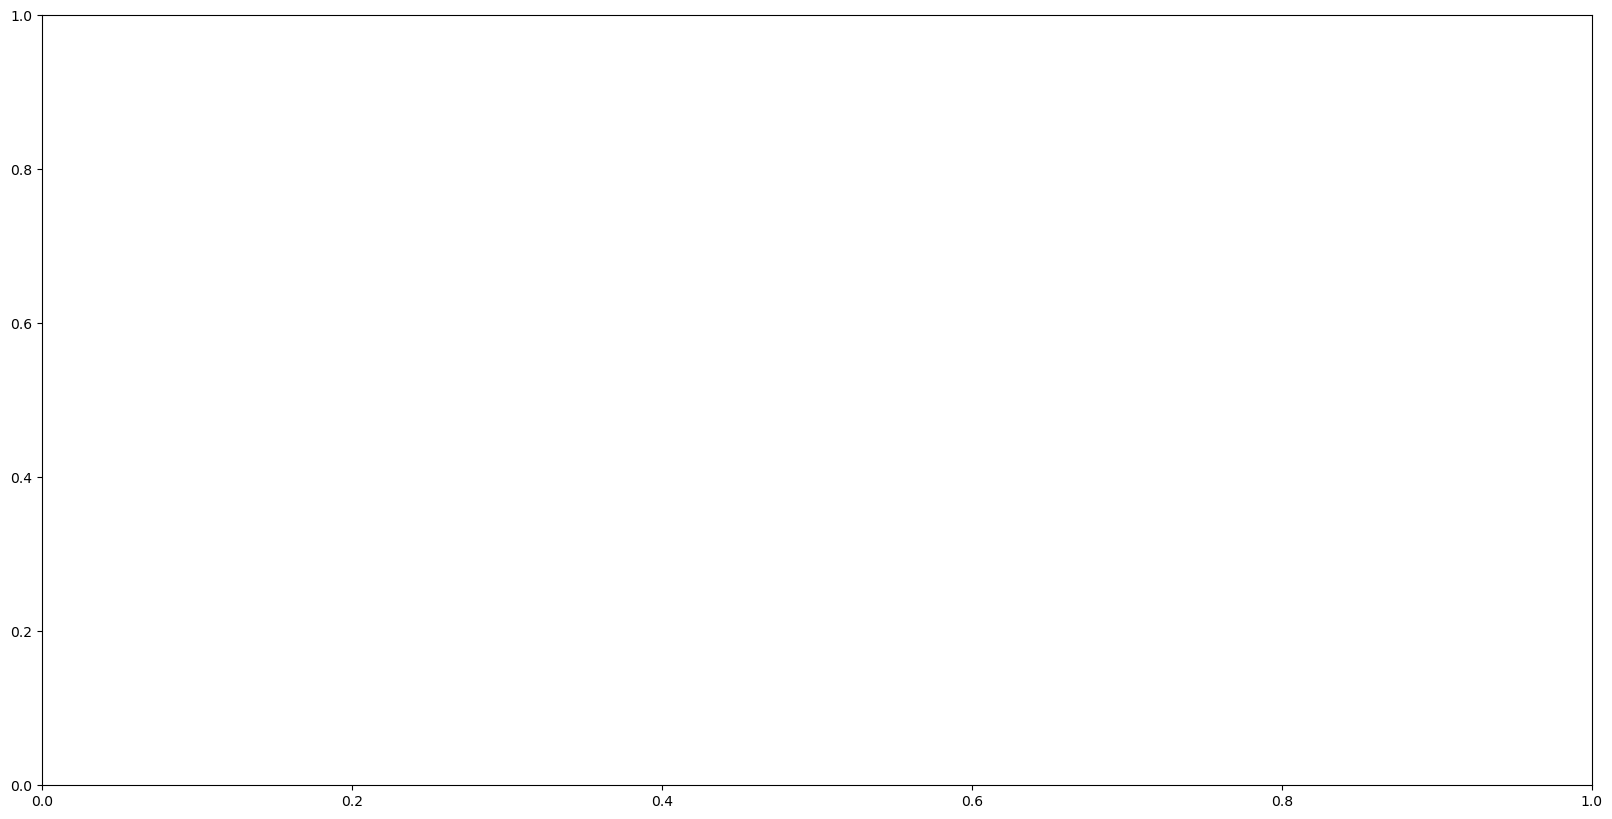

In [7]:
# Doing for all until 100%

data = pd.read_csv('../Processed Datasets/StarCraft_Combined_Dataset.csv')  
# data.drop(columns=["Player1_Race","Player2_Race"],axis=1,inplace=True)
# label encode player races
label_encoder = LabelEncoder()
label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


# Drop columns with non-numeric data (except for 'Player1_Race' and 'Player2_Race', which we'll one-hot encode)
data_numeric = data.select_dtypes(include=[np.number])

# Calculate correlations with the 'Winner' column
correlations = data_numeric.corrwith(data_numeric['Winner']).sort_values(ascending=False)

# Select top 5 correlating features (excluding 'Winner' itself)
top_features = correlations.index[1:10]  # Excluding 'Winner' which is at the top


def calculate_for_per2(per):
    # Function to filter groups with at least 120 rows
    def filter_groups(group):
        if len(group) >= per:
            return group.iloc[:per]  # Return only the first 120 rows

    # Group by 'replayID', apply the filter function
    filtered_groups = data.groupby('ReplayID').apply(filter_groups).reset_index(drop=True)
    # Add races back for one-hot encoding
    features_to_use = list(top_features) + ["ReplayID"]
    X = filtered_groups[features_to_use]
    y = filtered_groups['Winner']

    # Convert 1 to 0 and 2 to 1
    y_encoded = y.apply(lambda x: 0 if x == 1 else 1)
    y_encoded = y_encoded[X.index]

    # Preprocess the dataset
    numeric_features = top_features
    # categorical_features = ['Player1_Race', 'Player2_Race']

    # Assuming filtered_groups is your DataFrame from the previous step
    unique_replay_ids = filtered_groups['ReplayID'].unique()

    # Split the unique replay IDs into train and test sets
    train_replay_ids, test_replay_ids = train_test_split(unique_replay_ids, test_size=0.2, random_state=42)

    # Use the replay IDs to separate the original filtered_groups into train and test DataFrames
    train_X_data = X[X['ReplayID'].isin(train_replay_ids)]
    test_X_data = X[X['ReplayID'].isin(test_replay_ids)]
    train_y_data = y_encoded[X['ReplayID'].isin(train_replay_ids)]
    test_y_data = y_encoded[X['ReplayID'].isin(test_replay_ids)]

    # Create a column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
            ]
    )
    # Build the LSTM model
    def build_model(input_shape):
        model = Sequential([
            LSTM(60,return_sequences=True,input_shape=input_shape),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(1, activation='sigmoid') 
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    # Final Preprocessing

    # Preprocess the data
    preprocessor.fit(filtered_groups)
    X_train_processed = preprocessor.transform(train_X_data)
    X_test_processed = preprocessor.transform(test_X_data)

    # Reshape data for LSTM input
    feature_columns = [col for col in train_X_data.columns if col not in ['ReplayID', 'Winner']]
    X_train_reshaped = X_train_processed.reshape(-1, per, len(feature_columns))
    X_test_reshaped = X_test_processed.reshape(-1, per, len(feature_columns))

    # Create a mapping from ReplayID to label
    replay_id_to_label_map = {replay_id: label for replay_id, label in zip(X['ReplayID'], y_encoded)}

    # Now, extract the labels for the training and testing ReplayIDs in the correct order
    train_y_data = np.array([replay_id_to_label_map[replay_id] for replay_id in train_replay_ids])
    test_y_data = np.array([replay_id_to_label_map[replay_id] for replay_id in test_replay_ids])
    # Build and train the model
    model = build_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_reshaped, train_y_data, epochs=100, batch_size=16, validation_split=0.1, verbose=1, callbacks=[early_stopping])


    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, test_y_data, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

    # Return cross-validation scores
    return test_acc

plt.figure(figsize=(20, 10))
temp = []
for i in range(10, 220, 20):
    nn = calculate_for_per2(i)
    temp.append(nn)


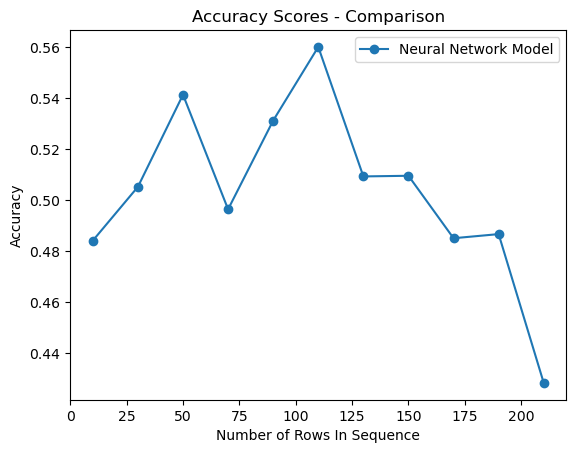

In [8]:
plt.plot(range(10, 220, 20),temp, marker='o', linestyle='-', label = "Neural Network Model")
plt.xlabel('Number of Rows In Sequence')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores - Comparison')
plt.legend()
plt.show()